polar to cartesian
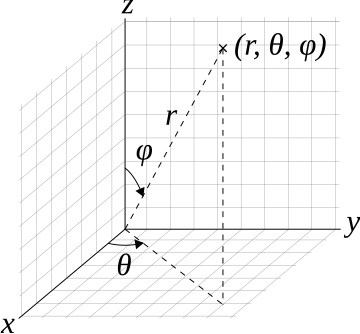

### installs

In [1]:
#check if this colab environment
on_colab = 'google.colab' in str(get_ipython())


In [2]:
import os

In [3]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

In [4]:
# !wget https://github.com/NVIDIAGameWorks/kaolin/raw/4d8f49dd3e617cb1fec3e2c2bc3b2903ff952321/examples/samples/rendered_clock.zip
# !unzip rendered_clock.zip
if on_colab:
  !git clone https://github.com/NVIDIAGameWorks/kaolin.git
  !pip install kaolin==0.16.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu121.html --quiet
  !pip install torch torchvision transformers diffusers pillow  --quiet
  !pip install objaverse --quiet
  !pip install lpips
  !pip install -U "comet_ml>=3.44.0" --quiet
  !cp /content/kaolin/kaolin/render/lighting/sg.py /usr/local/lib/python3.10/dist-packages/kaolin/render/lighting/sg.py
# !wget https://raw.githubusercontent.com/NVIDIAGameWorks/kaolin/bcbc92f4ed6f176e9d320932ea5ee1262e2ce059/examples/samples/sphere.obj

In [5]:
if on_colab:
  checkpoint_root = '/content/drive/MyDrive/Adver_diff_checkpoints/'
else:
  checkpoint_root = '/home/dcor/niskhizov/adv_diff_checkpoints/'

In [6]:
#@title comet stuff
import comet_ml
from comet_ml.integration.pytorch import watch

comet_ml.login(project_name="Adversarial-diff-rendering-notebook-V3")

In [7]:
from IPython.display import clear_output
clear_output()

### imports

In [8]:
import kaolin
import kaolin as kal
import pickle
import torch
import objaverse


import math
import matplotlib.pyplot as plt

from kaolin.render.lighting import SgLightingParameters
import numpy as np

from datetime import datetime

Warp 1.4.2 initialized:
   CUDA Toolkit 12.6, Driver 12.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3090" (24 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/dcor/niskhizov/.cache/warp/1.4.2


###  dynamic light, camera rendering funcs

In [ ]:


IMAGE_SIZE = 1024

def make_camera(eye):
  return kal.render.camera.Camera.from_args(eye=torch.tensor(eye),
                                         at=torch.tensor([0., 0., 0.]),
                                         up=torch.tensor([0., 1., 0]),
                                         fov=math.pi * 45 / 180,
                                            near=0.1, far=10000.,
                                         width=IMAGE_SIZE,
                                            height=IMAGE_SIZE,
                                            device='cuda')
forbidden_theta = []
forbidden_phi = []

resolution = 20
for theta in np.linspace(1, 0.9, 3):
    forbidden_theta.append(theta)

for phi in np.linspace(0.001, 3, resolution):
    forbidden_phi.append(phi)

forbidden_theta = set(forbidden_theta)
forbidden_phi = set(forbidden_phi)

def random_polar(r_range, phi_range, theta_range):
  done = False
  while not done:
    r = np.random.uniform(r_range[0], r_range[1])
    theta = np.random.uniform(theta_range[0], theta_range[1])
    phi = np.random.uniform(phi_range[0], phi_range[1])
    if theta not in forbidden_theta and phi not in forbidden_phi:
      done = True
  return [r, theta, phi]


def polar_to_cartesian(r, phi, theta):
  y = r * math.cos(theta)
  z = r * math.sin(theta) * math.cos(phi)
  x = r * math.sin(theta) * math.sin(phi)
  return [x,y,z]

def random_light(strength_range = [8,15],suns_range=[1, 5], phi_range=[0, math.pi * 2], theta_range=[0, math.pi / 2]):
  n_suns = int(np.random.uniform(suns_range[0],suns_range[1]))
  light_directions = []
  for i in range(n_suns):
    [r, theta, phi] = random_polar(r_range=[1, 5], phi_range=phi_range, theta_range=theta_range)
    direction = np.array(polar_to_cartesian(r, phi, theta))
    direction = direction / np.sqrt(np.sum(direction * direction))
    light_directions.append(direction)

  light_directions = torch.tensor(np.array(light_directions)).cuda()

  strength = np.random.uniform(strength_range[0],strength_range[1])
  lighting = SgLightingParameters.from_sun(light_directions.float(), strength).cuda()

  return lighting, (strength,light_directions)

def polar_camera_and_light(r, phi, theta):
  eye = polar_to_cartesian(r, phi, theta)
  camera = make_camera(eye)
  eye = np.array(eye)
  eye_norm = np.sqrt(np.sum(eye * eye))

  n_suns = int(np.random.uniform(1, 5))
  light_directions = []
  light_direction = torch.tensor(eye / eye_norm, dtype=torch.float32).view(1, 1, 3).cuda()
  strength = np.random.uniform(4, 10)
  lighting = SgLightingParameters.from_sun(light_direction.float(), strength).cuda()
  return camera, lighting

theta_eps = 0.3

def random_camera_and_light(r_range = [0, 5], phi_range=[0, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,0]):
  [r, theta, phi] = random_polar(r_range, phi_range, theta_range)
  return polar_camera_and_light(r, phi, theta), (r, phi, theta)


def render(in_cam, mesh, lighting, pbr_mat=None):
    if pbr_mat is not None:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting, custom_materials = [pbr_mat])
    else:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting)
    img = render_res[kal.render.easy_render.RenderPass.render].squeeze(0).clamp(0, 1)
    return img

# Show simple render

### lpf noise

In [10]:
from torch import nn
import torch.nn.functional as F

def generate_low_frequency_noise_fft(noise, cutoff_ratio: float = 0.05):
    """Generates low-frequency noise using FFT-based filtering."""
    # Generate random white noise
    size = noise.shape[0]
    # Perform FFT to get frequency domain representation
    noise_fft = torch.fft.fft2(noise)

    # Shift the zero frequency component to the center
    noise_fft_shifted = torch.fft.fftshift(noise_fft)

    # Create a low-pass filter (circle mask in frequency domain)
    mask = torch.zeros_like(noise_fft_shifted)
    center = size // 2
    cutoff = int(center * cutoff_ratio)  # Controls how much low frequency is kept

    for i in range(size):
        for j in range(size):
            if (i - center) ** 2 + (j - center) ** 2 < cutoff ** 2:
                mask[i, j] = 1

    # Apply the mask to the FFT coefficients
    low_freq_fft = noise_fft_shifted * mask

    # Inverse FFT to convert back to spatial domain
    low_freq_fft_shifted_back = torch.fft.ifftshift(low_freq_fft)
    low_freq_noise = torch.fft.ifft2(low_freq_fft_shifted_back).real

    return low_freq_noise

class SmoothNoise(nn.Module):
  def __init__(self, noise_shape):
      super().__init__()
      # generate noise parameter for each of the 3 channels

      self.noise_parameter = nn.ParameterList([nn.Parameter(torch.randn(noise_shape,noise_shape)) for i in range(3)])

  def forward(self, texture_map):
      all_channels_noise =  torch.stack([generate_low_frequency_noise_fft(p) for p in self.noise_parameter])
      if texture_map.shape[-1] == 3:
        all_channels_noise = all_channels_noise.T
      output = texture_map + all_channels_noise
      return output


def gaussian_kernel(size: int, sigma: float):
    """Generates a 2D Gaussian kernel."""
    coords = torch.arange(size).float()
    coords -= (size - 1) / 2.0
    g = torch.exp(-coords.pow(2) / (2 * sigma ** 2))
    g = g / g.sum()  # Normalize
    g_2d = g.unsqueeze(0) * g.unsqueeze(1)  # Outer product to create 2D kernel
    return g_2d

# Create Gaussian kernel
kernel_size = 11  # Kernel size (odd number)
sigma = 10        # Standard deviation of the Gaussian
num_noises = 1
gaussian_filter = gaussian_kernel(kernel_size, sigma).unsqueeze(0).repeat(3,1,1).unsqueeze(1)

conv_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=kernel_size,
                       padding=kernel_size // 2, bias=False,
                       padding_mode='circular', groups=3)

# Initialize the Conv2d weights with the Gaussian kernel
with torch.no_grad():
    conv_layer.weight = nn.Parameter(gaussian_filter)

#freeze conv_layer parameters
for param in conv_layer.parameters():
  param.requires_grad = False

class GNSmoothNoise(nn.Module):
  def __init__(self, noise_shape, num_noises=num_noises, zero_init=True):
      super().__init__()
      # generate noise parameter for each of the 3 channels
      self.kernel_size = kernel_size
      self.noise_parameter = nn.Parameter(torch.randn(num_noises,3,noise_shape,noise_shape)*5)
      if zero_init:
        self.noise_parameter.data = torch.zeros_like(self.noise_parameter) - 10

      self.conv_layer = conv_layer


  def forward(self, texture_map):
      return texture_map + conv_layer(self.noise_parameter).sum(0) * 0.1#(texture_map +  torch.sigmoid(self.conv_layer(self.noise_parameter).sum(0) ))/2

### Photographic augmentations

In [11]:
#@title augmentation
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

class PrintPhotographEffect:
    def __init__(self):
        self.downscale = T.Resize((300, 300))  # Simulate low-res printing
        self.upscale = T.Resize((1024, 1024))  # Upscale back to original size
        self.add_noise = T.Lambda(self._add_noise)  # Add random noise
        self.gaussian_blur = T.GaussianBlur(kernel_size=(5,5), sigma=(1.0, 4.0))  # Blur
        self.adjust_contrast = T.Lambda(self._adjust_contrast)  # Contrast adjustment
        self.vignette = T.Lambda(self._add_vignette)  # Vignette effect
        self.jitter = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5)
        # self.perspective_transformer = v2.RandomPerspective(distortion_scale=0.2, p=1.0)

    def _add_noise(self, img):
        rnd_scale = torch.FloatTensor(1).uniform_(0.01, 0.2).to(img.device)
        noise = torch.randn_like(img) * rnd_scale  # Gaussian noise
        return torch.clamp(img + noise, 0, 1)

    def _adjust_contrast(self, img,factor=1.2):
        factor = factor  # Slightly increase contrast
        mean = torch.mean(img, dim=(-2, -1), keepdim=True)
        return torch.clamp((img - mean) * factor + mean, 0, 1)

    def _add_vignette(self, img):
        _, height, width = img.shape
        y, x = torch.meshgrid(
            torch.linspace(-1, 1, height, device=img.device),
            torch.linspace(-1, 1, width, device=img.device)
        )
        vignette = 1 - torch.sqrt(x**2 + y**2)
        vignette = vignette.to(img.device).unsqueeze(0)  # Add channel dimension
        return torch.clamp(img * vignette, 0, 1)

    def __call__(self, img,upscale_first=False):
        img = img.permute(2,1,0)
        img = self.downscale(img)
        if upscale_first:
          img = self.upscale(img)

        img = self.add_noise(img)

        img = self.gaussian_blur(img)

        # img = self.adjust_contrast(img)

        img = self.jitter(img)
        # img = self.vignette(img)

        # img = self.perspective_transformer(img)
        if not upscale_first:
          img = self.upscale(img)

        return img.permute(2,1,0)

effect = PrintPhotographEffect()


### resnet classfier init

In [12]:


from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision


weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.eval().cuda()


preprocess = weights.transforms()
#input image w x h x c

def resnet_predict(image):
  with torch.no_grad():
    prediction = resnet_predict_raw(image)
    prediction = prediction.squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    # return(f"class id - {class_id} {category_name}: {100 * score:.1f}%")
    return(f"{category_name}: {100 * score:.1f}%")



def resnet_predict_raw(image):

  image = image.permute(2, 0, 1)

  if image.shape != (3, 256, 256):
    rimage = torchvision.transforms.Resize((256, 256))(image)
  else:
    rimage = image

  # Step 3: Apply inference preprocessing transforms
  batch = preprocess(rimage).unsqueeze(0)

  # Step 4: Use the model and print the predicted category
  return model(batch)

### objaverse

In [13]:
# for x,y in zip(range(len(weights.meta["categories"])),weights.meta["categories"]):
#   print(x,y)

In [14]:
import objaverse

uids = ['f53d75bd123b40bca14d12d54286f432']

objaverse.load_objects(
    uids,
    download_processes = 1
)

orig_mesh = kal.io.gltf.import_mesh(f'{os.path.expanduser("~")}/.objaverse/hf-objaverse-v1/glbs/000-027/f53d75bd123b40bca14d12d54286f432.glb')
orig_mesh.vertices = kal.ops.pointcloud.center_points(orig_mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/io/gltf.py:285: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1560.)
  output = torch.frombuffer(


In [15]:
import copy
mesh = copy.deepcopy(orig_mesh)

In [16]:
# lighting.amplitude.dtype

In [17]:
# lighting.from_sun

In [18]:
(camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 4])#,phi_range=[ 0.2,0.2] ,theta_range=[math.pi / 2 - theta_eps, math.pi / 2 - theta_eps])
lighting, (strength,light_directions) = random_light(strength_range=[20,30])#kal.render.easy_render.default_lighting().cuda()
print(strength,light_directions)
# lighting.amplitude = torch.ones(1,3).cuda() * 8

print(r)


# mesh.materials[0].diffuse_texture = mesh.materials[0].diffuse_texture

img = render(camera, mesh.cuda(), lighting.cuda())

plt.imshow(img.detach().cpu())


resnet_predict(torch.tensor(img).cuda())

22.771485109098577 tensor([[-0.1921,  0.9539,  0.2304],
        [ 0.3478,  0.9179,  0.1911],
        [-0.3536,  0.6840, -0.6381]], device='cuda:0', dtype=torch.float64)
1.7925731973751655


/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/render/easy_render/mesh.py:282: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  im_bitangents = torch.nn.functional.normalize(torch.cross(im_tangents, im_base_normals), dim=-1)
/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_508265/1163450222.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

'orange: 15.8%'

In [19]:

batch_size = 1

# analog_clock_class = torch.tensor([409]*batch_size).cuda()
# wall_clock_class = torch.tensor([892]*batch_size).cuda()
# orig_class = torch.tensor([948]*batch_size).cuda()
orig_clases = [torch.tensor([x]*batch_size).cuda() for x in range(948,959)]



critereon = torch.nn.CrossEntropyLoss()
adv_direction = 100 #None#953# pineapple #None



if adv_direction:
  directed_class = torch.tensor([adv_direction]*batch_size).cuda()

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [21]:
SN = GNSmoothNoise(1024, zero_init=False).to(device)

#### load saved weights
find the most recent file in /content/drive/MyDrive/Adver_diff_checkpoints

In [22]:

# import glob
# import re
# import os
# import torch
# # weights_paths = glob.glob('/content/drive/MyDrive/Adver_diff_checkpoints/*_without_sds_bs_20.pt')
# # weights_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
# # print(weights_paths[-1])

# files = glob.glob('/home/dcor/niskhizov/adv_diff_checkpoints//*.pt')
# files.sort(key=os.path.getmtime)
# files

# SN.noise_parameter = torch.load(files[-1]).noise_parameter

In [ ]:
# orig_mesh.materials[0].diffuse_texture.min()

In [ ]:
# sn = SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()
# print(sn[0]==sn[1])
# # plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()[2])
# plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach().permute(2,1,0))
# # plt.imshow(SN.noise_parameter.data[5].cpu().permute(2,1,0))
# # plt.imshow(orig_mesh.materials[0].diffuse_texture,aspect='auto')

### sds stuff

In [25]:


from huggingface_hub import hf_hub_download
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModel,logging,CLIPProcessor
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, EulerDiscreteScheduler, AutoPipelineForImage2Image, StableDiffusionXLPipeline

# suppress partial model loading warning
logging.set_verbosity_error()

import torch
import torch.nn as nn
import torch.nn.functional as F
from loguru import logger
from safetensors.torch import load_file

import time

class StableDiffusion(nn.Module):
    def __init__(self, device, model_name='CompVis/stable-diffusion-v1-4',concept_name=None, latent_mode=True):
        super().__init__()

        try:
            with open('./TOKEN', 'r') as f:
                self.token = f.read().replace('\n', '') # remove the last \n!
                logger.info(f'loaded hugging face access token from ./TOKEN!')
        except FileNotFoundError as e:
            self.token = True
            logger.warning(f'try to load hugging face access token from the default place, make sure you have run `huggingface-cli login`.')

        self.device = device
        self.latent_mode = latent_mode
        self.num_train_timesteps = 1000
        self.min_step = int(self.num_train_timesteps * 0.02)
        self.max_step = int(self.num_train_timesteps * 0.98)

        logger.info(f'loading stable diffusion with {model_name}...')

        # 1. Load the autoencoder model which will be used to decode the latents into image space.
        self.vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_auth_token=self.token).to(self.device)

        # 2. Load the tokenizer and text encoder to tokenize and encode the text.
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(self.device)
        self.image_encoder = None
        self.image_processor = None


        # 3. The UNet model for generating the latents.
        self.unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_auth_token=self.token).to(self.device)


        # print('USING LIGHTNING')
        # # Load model.

        # num_inference_steps = 2
        # base_model = "stabilityai/stable-diffusion-xl-base-1.0"
        # model_repo = "ByteDance/SDXL-Lightning"
        # model_ckpt = f"sdxl_lightning_{num_inference_steps}step_unet.safetensors"
        # self.unet = UNet2DConditionModel.from_config(base_model, subfolder="unet").to('cuda')
        # self.unet.load_state_dict(load_file(hf_hub_download(model_repo, model_ckpt)))

        # pipe = StableDiffusionXLPipeline.from_pretrained(base_model, torch_dtype=torch.float16, variant="fp16")

# Ensure sampler uses "trailing" timesteps.

        # self.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

        # del pipe

        # 4. Create a scheduler for inference
        self.scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=self.num_train_timesteps)
        self.alphas = self.scheduler.alphas_cumprod.to(self.device) # for convenience

        if concept_name is not None:
            self.load_concept(concept_name)
        logger.info(f'\t successfully loaded stable diffusion!')

    def load_concept(self, concept_name):
        repo_id_embeds = f"sd-concepts-library/{concept_name}"
        learned_embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin")
        token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt")
        with open(token_path, 'r') as file:
            placeholder_token_string = file.read()

        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = self.text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = trained_token
        num_added_tokens = self.tokenizer.add_tokens(token)
        if num_added_tokens == 0:
            raise ValueError(
                f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")

        # resize the token embeddings
        self.text_encoder.resize_token_embeddings(len(self.tokenizer))

        # get the id for the token and assign the embeds
        token_id = self.tokenizer.convert_tokens_to_ids(token)
        self.text_encoder.get_input_embeddings().weight.data[token_id] = embeds

    def get_text_embeds(self, prompt):
        # Tokenize text and get embeddings
        text_input = self.tokenizer(prompt, padding='max_length', max_length=self.tokenizer.model_max_length, truncation=True, return_tensors='pt')

        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # Do the same for unconditional embeddings
        uncond_input = self.tokenizer([''] * len(prompt), padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')

        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        # Cat for final embeddings
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        return text_embeddings


    def train_step(self, text_embeddings, inputs, guidance_scale=100):

        # interp to 512x512 to be fed into vae.

        # _t = time.time()
        if not self.latent_mode:
        # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
            pred_rgb_512 = F.interpolate(inputs, (512, 512), mode='bilinear', align_corners=False)
            latents = self.encode_imgs(pred_rgb_512)
        else:
            latents = inputs
        # torch.cuda.synchronize(); print(f'[TIME] guiding: interp {time.time() - _t:.4f}s')

        # timestep ~ U(0.02, 0.98) to avoid very high/low noise level
        t = torch.randint(self.min_step, self.max_step + 1, [1], dtype=torch.long, device=self.device)

        # encode image into latents with vae, requires grad!
        # _t = time.time()

        # torch.cuda.synchronize(); print(f'[TIME] guiding: vae enc {time.time() - _t:.4f}s')

        # predict the noise residual with unet, NO grad!
        # _t = time.time()
        with torch.no_grad():
            # add noise
            noise = torch.randn_like(latents)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)
            # pred noise
            latent_model_input = torch.cat([latents_noisy] * 2)
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # torch.cuda.synchronize(); print(f'[TIME] guiding: unet {time.time() - _t:.4f}s')

        # perform guidance (high scale from paper!)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # w(t), alpha_t * sigma_t^2
        # w = (1 - self.alphas[t])
        w = self.alphas[t] ** 0.5 * (1 - self.alphas[t])
        grad = w * (noise_pred - noise)

        # clip grad for stable training?
        # grad = grad.clamp(-1, 1)

        # manually backward, since we omitted an item in grad and cannot simply autodiff.
        # _t = time.time()
        latents.backward(gradient=grad, retain_graph=True)
        # torch.cuda.synchronize(); print(f'[TIME] guiding: backward {time.time() - _t:.4f}s')

        return grad # dummy loss value

    def produce_latents(self, text_embeddings, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if latents is None:
            latents = torch.randn((text_embeddings.shape[0] // 2, self.unet.in_channels, height // 8, width // 8), device=self.device)

        self.scheduler.set_timesteps(num_inference_steps)

        with torch.autocast('cuda'):
            for i, t in enumerate(self.scheduler.timesteps):
                # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                latent_model_input = torch.cat([latents] * 2)

                # predict the noise residual
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents)['prev_sample']

        return latents

    def decode_latents(self, latents):
        # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
        latents = 1 / 0.18215 * latents

        with torch.no_grad():
            imgs = self.vae.decode(latents).sample

        imgs = (imgs / 2 + 0.5).clamp(0, 1)

        return imgs

    def encode_imgs(self, imgs):
        # imgs: [B, 3, H, W]

        imgs = 2 * imgs - 1

        posterior = self.vae.encode(imgs).latent_dist
        latents = posterior.sample() * 0.18215

        return latents

    def prompt_to_img(self, prompts, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if isinstance(prompts, str):
            prompts = [prompts]

        # Prompts -> text embeds
        text_embeds = self.get_text_embeds(prompts) # [2, 77, 768]

        # Text embeds -> img latents
        latents = self.produce_latents(text_embeds, height=height, width=width, latents=latents, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale) # [1, 4, 64, 64]

        # Img latents -> imgs
        imgs = self.decode_latents(latents) # [1, 3, 512, 512]

        # Img to Numpy
        imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
        imgs = (imgs * 255).round().astype('uint8')

        return imgs

In [ ]:
import torch.nn.functional as F


In [27]:
sd = StableDiffusion('cuda',latent_mode=False)
prompt = 'high resolution image of an apple'

text_embed = sd.get_text_embeds([prompt])

2024-12-01 22:28:32.606 | WARNING  | __main__:__init__:27 - try to load hugging face access token from the default place, make sure you have run `huggingface-cli login`.
2024-12-01 22:28:32.607 | INFO     | __main__:__init__:35 - loading stable diffusion with CompVis/stable-diffusion-v1-4...
2024-12-01 22:29:29.925 | INFO     | __main__:__init__:75 - 	 successfully loaded stable diffusion!


### training

In [ ]:
texture_noise_optim = torch.optim.Adam(params=list(p for p in SN.parameters() if p.requires_grad), lr=0.01)
#add lr reduce scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(texture_noise_optim, mode='min', factor=0.1, patience=10, verbose=True)

In [29]:
# import lpips
# # loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

In [30]:
#freeze all parameters of resnet model
model = model.to(device)
for param in model.parameters():
  param.requires_grad = False

mesh = mesh.to(device)
orig_mesh = orig_mesh.to(device)

In [31]:
plt.imshow(effect(img).cpu())

In [32]:
import tqdm

In [ ]:
from comet_ml.integration.pytorch import log_model

start_time = str(datetime.now()).split('.')[0]

USE_LPIPS = False
lpips_lambda = 100
adv_lambda = 300

effective_batch_size = 1

sds_steps = 1
augment_prob = 0.9
sds_grad = 0
sds_grad_norm = 0

print(f'exeriment time {start_time}')
experiment = comet_ml.Experiment(display_summary_level=0, log_code=True)


exp_name = f'{sds_steps}_sds_bs_{effective_batch_size}_agg_loss_blsw_photo_augmentations'

complete_name = exp_name+'_'+start_time

experiment.set_name(complete_name)
experiment.log_code()
experiment.end()

experiment = comet_ml.ExistingExperiment(display_summary_level=0, previous_experiment=experiment.get_key())



# log kernel_size and sigma as hyper param to comet

import os

watch(SN)


experiment.log_parameters({"kernel_size": kernel_size, "sigma": sigma,
                           "num_noises": num_noises, "effective_batch_size":effective_batch_size, "sds_steps": sds_steps, "augment_prob":augment_prob,"prompt":prompt})


experiment.log_parameters({"lpips_lambda": lpips_lambda})


try:
  for idx in tqdm.tqdm_notebook(range(350000)):
          (camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.8, 2.5], phi_range=[0.01, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,0.01])
          lighting, _ = random_light(strength_range=[16,30],suns_range=[3,7])
          lighting = lighting.cuda()
          gt_image = render(camera, orig_mesh.cuda(), lighting)
          
          prediction_aug = None

          ### Render
          #is it the same as comparing the textures directly ?







          texture_noise_optim.zero_grad()


          mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T

          image = render(camera, mesh.cuda(), lighting)

          zero_mask = image != 0
          img_loss = torch.mean(torch.abs((image - gt_image)[zero_mask]))


          augment_choise = torch.rand(1)
          if augment_choise < augment_prob:
            image_aug = effect(image)
            prediction_aug = resnet_predict_raw(image_aug)


          prediction = resnet_predict_raw(image)

          ## nan handle
          if torch.sum(prediction != prediction) != 0:
            print('nan found in prediction')
            texture_noise_optim.zero_grad()
            continue

          # print(prediction.argmax(1))
          aug_pred_loss = 0
          if adv_direction:
            adv_loss =  critereon(prediction, directed_class)
            if prediction_aug is not None:
                aug_pred_loss = critereon(prediction_aug, directed_class)
                adv_loss += aug_pred_loss
          else:
            p = prediction.squeeze(0).softmax(0)
            adv_loss = torch.stack([p[c.item()] for c in orig_clases]).max()
            if prediction_aug is not None:
                p = prediction_aug.squeeze(0).softmax(0)
                aug_pred_loss = torch.stack([p[c.item()] for c in orig_clases]).max()
                adv_loss += aug_pred_loss
            # adv_loss = sum([prediction[c] for c in orig_clases]) #-1 * sum([critereon(prediction, c)  for c in orig_clases])


          ### Compute Losses ###


          if USE_LPIPS:
            lpips_loss = loss_fn_vgg(image.permute(2,1,0), gt_image.permute(2,1,0), normalize=True).mean()
          else:
            lpips_loss = 0


          # if img_loss > 0.1 :
          #   effective_adv_lambda = 0
          # else:
          #   effective_adv_lambda = adv_lambda

          total_loss =  lpips_loss*lpips_lambda + adv_loss*adv_lambda 

          if torch.sum(total_loss != total_loss) != 0:
            raise
          ### Update the mesh ###
          total_loss.backward( retain_graph=True)
          # print(torch.stack([x.grad.sum() for x in list(SN.parameters())]))
          # vertices_optim.step()
          grad_norm =  SN.noise_parameter.grad.norm()

          if grad_norm != grad_norm:
            print('grad norm is nan')
            texture_noise_optim.zero_grad()
            continue

          if adv_loss < 2 :

            for i in range(sds_steps):

              grad = sd.train_step(text_embed, image.permute(2,0,1).unsqueeze(0))

              sds_grad_norm = grad.norm()

              # sds_grad += grad / sds_steps
              if sds_grad_norm != sds_grad_norm:
                print('sds nan')
                texture_noise_optim.zero_grad()

                continue

          texture_noise_optim.step()

          # if idx % effective_batch_size == 0:
          #       if grad_norm != grad_norm:
          #         print('grad norm is nan')
          #         texture_noise_optim.zero_grad()
          #         continue
          #       texture_noise_optim.step()
          #       texture_noise_optim.zero_grad()
                # if sds_steps > 0:
                #   sds_grad_norm = sds_grad.norm()
                # sds_grad = 0



          # texture_noise_optim.step()
          # scheduler.step(total_loss)

          # vertices_scheduler.step()
          # texture_scheduler.step()
          if idx % 100 == 0:
            plt.imshow(image.detach().cpu())
            plt.show()
            print(f"idx {idx} - img_loss: {float(img_loss)}, adv_loss {adv_loss}, grad norm {grad_norm}, lpips_loss {lpips_loss}")


          if idx % 10 == 0:
            # plt.imshow(image.detach().cpu())
            # plt.show()
            experiment.log_metrics({"img_loss": float(img_loss), "adv_loss": float(adv_loss),
                                    "lpips_loss":lpips_loss, "sds_grad_norm":sds_grad_norm, "grad_norm": grad_norm, "aug_pred_loss": aug_pred_loss}, step=idx)
            if idx % 200 == 0:
                irs = resnet_predict(torch.tensor(image.detach().cpu()).cuda())
                gtrs = resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda())
                experiment.log_text(f'(r, phi, theta) - {r}, {phi}, {theta}')
                experiment.log_text('adversarial image highest class - '+irs)
                experiment.log_text('gt image highest class - '+gtrs)
                experiment.log_image(image_data=image.detach().cpu(), name="image", step=idx)

          if idx % 2000 == 0:
            print(f"idx {idx} - img_loss: {float(img_loss)}, adv_loss {adv_loss}, grad norm {grad_norm}, lpips_loss {lpips_loss}")
            # log adv loss and img loss to experiment
            print(resnet_predict(torch.tensor(image.detach().cpu()).cuda()))
            print(resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda()))
            # save model to drive
            os.makedirs(checkpoint_root, exist_ok=True)
            torch.save(SN, checkpoint_root + '/' + str(idx) + f'_{complete_name}.pt')
            log_model(model_name='gaussian_lpf_noise', experiment=experiment ,model=SN)
            
except KeyboardInterrupt:
  print('terminated')
  experiment.end()
except Exception as e:
  experiment.end()
  raise e

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


exeriment time 2024-12-01 22:29:31


COMET INFO: Experiment is live on comet.com https://www.comet.com/dannynis/adversarial-diff-rendering-notebook-v3/8caf2d4643d14e20b98fc7b8bfe35bf7

COMET WARNING: unable to find caller source code in a jupyter notebook; ignoring
COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Couldn't find a Git repository in '/home/dcor/niskhizov' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dannynis/adversarial-diff-rendering-notebook-v3/8caf2d4643d14e20b98fc7b8bfe35bf7

COMET INFO: Skipping weight and bias logging for non-trainable layers: 
    conv_layer.weight
/tmp/ipykernel_508265/2014140258.py:47: TqdmDeprec

  0%|          | 0/350000 [00:00<?, ?it/s]

/tmp/ipykernel_508265/2014140258.py:67: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T
/tmp/ipykernel_508265/2014140258.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/tmp/ipykernel_508265/2014140258.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  irs = resnet_predict(torch.tensor(image.detach().cpu()).cuda())
/tmp/ipykernel_508265/2014140258.py:183: UserWarning: To copy construct from a ten

idx 0 - img_loss: 0.04332760348916054, adv_loss 15.392354965209961, grad norm 11.902018547058105, lpips_loss 0
idx 0 - img_loss: 0.04332760348916054, adv_loss 15.392354965209961, grad norm 11.902018547058105, lpips_loss 0
pomegranate: 18.2%
orange: 11.3%


/tmp/ipykernel_508265/2014140258.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(resnet_predict(torch.tensor(image.detach().cpu()).cuda()))
/tmp/ipykernel_508265/2014140258.py:193: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda()))


idx 100 - img_loss: 0.05303170531988144, adv_loss 15.995878219604492, grad norm 30.363554000854492, lpips_loss 0
idx 200 - img_loss: 0.031453005969524384, adv_loss 15.468412399291992, grad norm 7.112335205078125, lpips_loss 0
idx 300 - img_loss: 0.027122369036078453, adv_loss 15.658430099487305, grad norm 13.86086654663086, lpips_loss 0
idx 400 - img_loss: 0.05014912784099579, adv_loss 15.13675308227539, grad norm 11.978506088256836, lpips_loss 0
idx 500 - img_loss: 0.049862563610076904, adv_loss 15.189370155334473, grad norm 10.050223350524902, lpips_loss 0
idx 600 - img_loss: 0.05167263001203537, adv_loss 14.985998153686523, grad norm 13.298442840576172, lpips_loss 0
idx 700 - img_loss: 0.044522423297166824, adv_loss 7.481016159057617, grad norm 5.461824417114258, lpips_loss 0
idx 800 - img_loss: 0.0404585525393486, adv_loss 15.25906753540039, grad norm 9.84512996673584, lpips_loss 0
idx 900 - img_loss: 0.055450331419706345, adv_loss 14.755563735961914, grad norm 10.616657257080078, 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpogvxvkin, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpsjiur27d, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 100100 - img_loss: 0.15573756396770477, adv_loss 0.8450926542282104, grad norm 15.13147258758545, lpips_loss 0
idx 100200 - img_loss: 0.24058373272418976, adv_loss 0.775211751461029, grad norm 15.089375495910645, lpips_loss 0
idx 100300 - img_loss: 0.16698139905929565, adv_loss 0.7078943848609924, grad norm 6.392871856689453, lpips_loss 0
idx 100400 - img_loss: 0.20077618956565857, adv_loss 1.3373961448669434, grad norm 30.085372924804688, lpips_loss 0
nan found in prediction
idx 100500 - img_loss: 0.2492789775133133, adv_loss 0.8933670520782471, grad norm 20.52606773376465, lpips_loss 0
idx 100600 - img_loss: 0.25982317328453064, adv_loss 0.3984011709690094, grad norm 5.59895658493042, lpips_loss 0
idx 100700 - img_loss: 0.23774945735931396, adv_loss 0.2700144052505493, grad norm 5.352797985076904, lpips_loss 0
idx 100800 - img_loss: 0.18957875669002533, adv_loss 0.6811071634292603, grad norm 7.32220983505249, lpips_loss 0
idx 100900 - img_loss: 0.23172247409820557, adv_loss 0.686

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp5t5zvgxh, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpl8zlwxv5, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 102100 - img_loss: 0.16865874826908112, adv_loss 0.7012088298797607, grad norm 4.594024658203125, lpips_loss 0
idx 102200 - img_loss: 0.25515231490135193, adv_loss 0.3028024137020111, grad norm 6.666772842407227, lpips_loss 0
idx 102300 - img_loss: 0.25932228565216064, adv_loss 0.562677264213562, grad norm 7.313476085662842, lpips_loss 0
idx 102400 - img_loss: 0.2468886375427246, adv_loss 0.5997112393379211, grad norm 5.971168518066406, lpips_loss 0
idx 102500 - img_loss: 0.20467284321784973, adv_loss 0.7659527063369751, grad norm 12.345069885253906, lpips_loss 0
idx 102600 - img_loss: 0.29075682163238525, adv_loss 0.2912359833717346, grad norm 7.657189846038818, lpips_loss 0
idx 102700 - img_loss: 0.26480066776275635, adv_loss 0.4290209114551544, grad norm 5.343288898468018, lpips_loss 0
idx 102800 - img_loss: 0.14780035614967346, adv_loss 0.16533829271793365, grad norm 2.3697314262390137, lpips_loss 0
idx 102900 - img_loss: 0.23834963142871857, adv_loss 0.5086667537689209, grad n

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp4gu6r3mo, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpxa48p1if, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 104100 - img_loss: 0.24968543648719788, adv_loss 0.1943163275718689, grad norm 6.06807279586792, lpips_loss 0
idx 104200 - img_loss: 0.18471792340278625, adv_loss 0.8397178053855896, grad norm 5.4042816162109375, lpips_loss 0
idx 104300 - img_loss: 0.2533476650714874, adv_loss 0.40631577372550964, grad norm 6.899989128112793, lpips_loss 0
idx 104400 - img_loss: 0.257649689912796, adv_loss 0.7955208420753479, grad norm 10.47431755065918, lpips_loss 0
idx 104500 - img_loss: 0.2217271625995636, adv_loss 0.11531676352024078, grad norm 3.041731119155884, lpips_loss 0
idx 104600 - img_loss: 0.2712666094303131, adv_loss 0.21037042140960693, grad norm 3.4599924087524414, lpips_loss 0
idx 104700 - img_loss: 0.22890125215053558, adv_loss 0.7369217872619629, grad norm 30.74520492553711, lpips_loss 0
nan found in prediction
idx 104800 - img_loss: 0.22960089147090912, adv_loss 0.9832229614257812, grad norm 10.946494102478027, lpips_loss 0
idx 104900 - img_loss: 0.19963982701301575, adv_loss 0.7

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpk9xdzlht, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp5jqggdqg, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 106100 - img_loss: 0.24666211009025574, adv_loss 0.05708438158035278, grad norm 1.4084086418151855, lpips_loss 0
idx 106200 - img_loss: 0.25059181451797485, adv_loss 0.2794165313243866, grad norm 7.643080711364746, lpips_loss 0
idx 106300 - img_loss: 0.2541355490684509, adv_loss 1.0129681825637817, grad norm 13.827418327331543, lpips_loss 0
idx 106400 - img_loss: 0.16687913239002228, adv_loss 0.4302184581756592, grad norm 8.355984687805176, lpips_loss 0
idx 106500 - img_loss: 0.25936272740364075, adv_loss 0.4251231551170349, grad norm 8.779504776000977, lpips_loss 0
idx 106600 - img_loss: 0.044161129742860794, adv_loss 9.071341514587402, grad norm 12.48507308959961, lpips_loss 0
idx 106700 - img_loss: 0.20766760408878326, adv_loss 0.3866163194179535, grad norm 5.262384414672852, lpips_loss 0
idx 106800 - img_loss: 0.2561766803264618, adv_loss 0.23903658986091614, grad norm 5.297064304351807, lpips_loss 0
idx 106900 - img_loss: 0.2282145768404007, adv_loss 0.21472099423408508, grad 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp1qulm4mq, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpqe8nmct9, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 108100 - img_loss: 0.2526223063468933, adv_loss 0.5294620990753174, grad norm 8.084573745727539, lpips_loss 0
idx 108200 - img_loss: 0.16516123712062836, adv_loss 0.7909933924674988, grad norm 10.846840858459473, lpips_loss 0
idx 108300 - img_loss: 0.2557781934738159, adv_loss 0.13122732937335968, grad norm 4.59230375289917, lpips_loss 0
idx 108400 - img_loss: 0.25457456707954407, adv_loss 0.34959545731544495, grad norm 7.074447154998779, lpips_loss 0
idx 108500 - img_loss: 0.26494377851486206, adv_loss 0.23997873067855835, grad norm 6.521700382232666, lpips_loss 0
idx 108600 - img_loss: 0.10652612894773483, adv_loss 2.762986421585083, grad norm 60.98887634277344, lpips_loss 0
idx 108700 - img_loss: 0.19929395616054535, adv_loss 3.97472882270813, grad norm 84.45732879638672, lpips_loss 0
idx 108800 - img_loss: 0.25439977645874023, adv_loss 0.7065456509590149, grad norm 9.749824523925781, lpips_loss 0
idx 108900 - img_loss: 0.2357385754585266, adv_loss 0.2726210355758667, grad norm 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpf431fop_, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmphqry8kan, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 110100 - img_loss: 0.2468174397945404, adv_loss 0.3491155803203583, grad norm 8.188939094543457, lpips_loss 0
nan found in prediction
idx 110200 - img_loss: 0.22066181898117065, adv_loss 0.5633786916732788, grad norm 8.082765579223633, lpips_loss 0
idx 110300 - img_loss: 0.2712824046611786, adv_loss 0.09643217921257019, grad norm 2.8182828426361084, lpips_loss 0
idx 110400 - img_loss: 0.26241227984428406, adv_loss 0.4644401967525482, grad norm 12.883685111999512, lpips_loss 0
idx 110500 - img_loss: 0.12135795503854752, adv_loss 3.052295207977295, grad norm 41.23735427856445, lpips_loss 0
nan found in prediction
idx 110600 - img_loss: 0.24119970202445984, adv_loss 0.13664758205413818, grad norm 3.9133338928222656, lpips_loss 0
idx 110700 - img_loss: 0.25230517983436584, adv_loss 0.501882791519165, grad norm 7.673462390899658, lpips_loss 0
idx 110800 - img_loss: 0.1594066023826599, adv_loss 2.9168083667755127, grad norm 31.48161506652832, lpips_loss 0
idx 110900 - img_loss: 0.2283703

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmprtamsgfv, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpm7ssr1rs, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 112100 - img_loss: 0.23567262291908264, adv_loss 0.961149275302887, grad norm 22.62667465209961, lpips_loss 0
idx 112200 - img_loss: 0.2476290762424469, adv_loss 0.39645689725875854, grad norm 9.675439834594727, lpips_loss 0
idx 112300 - img_loss: 0.2451269030570984, adv_loss 0.3056090772151947, grad norm 3.691725969314575, lpips_loss 0
idx 112400 - img_loss: 0.25444814562797546, adv_loss 0.7575610876083374, grad norm 7.802321434020996, lpips_loss 0
idx 112500 - img_loss: 0.24286964535713196, adv_loss 0.20183980464935303, grad norm 4.911253929138184, lpips_loss 0
idx 112600 - img_loss: 0.2585271894931793, adv_loss 0.3694915473461151, grad norm 7.371642112731934, lpips_loss 0
idx 112700 - img_loss: 0.1992654800415039, adv_loss 0.4833856225013733, grad norm 5.413783550262451, lpips_loss 0
idx 112800 - img_loss: 0.14037087559700012, adv_loss 0.3341735899448395, grad norm 7.56787109375, lpips_loss 0
idx 112900 - img_loss: 0.20758642256259918, adv_loss 0.9180169105529785, grad norm 9.09

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp9vybi8dr, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp8xcpceph, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 114100 - img_loss: 0.26985785365104675, adv_loss 0.5076548457145691, grad norm 8.304655075073242, lpips_loss 0
idx 114200 - img_loss: 0.2561402916908264, adv_loss 0.2182571142911911, grad norm 6.832004070281982, lpips_loss 0
idx 114300 - img_loss: 0.19335876405239105, adv_loss 0.47114771604537964, grad norm 7.386024475097656, lpips_loss 0
idx 114400 - img_loss: 0.16821148991584778, adv_loss 0.6591782569885254, grad norm 7.961723327636719, lpips_loss 0
idx 114500 - img_loss: 0.1450231522321701, adv_loss 0.9387764930725098, grad norm 16.88905143737793, lpips_loss 0
idx 114600 - img_loss: 0.26187923550605774, adv_loss 0.8376905918121338, grad norm 19.731063842773438, lpips_loss 0
idx 114700 - img_loss: 0.2096179723739624, adv_loss 0.29520779848098755, grad norm 5.8693084716796875, lpips_loss 0
idx 114800 - img_loss: 0.23153528571128845, adv_loss 0.8320695161819458, grad norm 12.738396644592285, lpips_loss 0
idx 114900 - img_loss: 0.19966921210289001, adv_loss 0.08266319334506989, grad

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmptmw74j6p, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp18so7z2r, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 116100 - img_loss: 0.2087671458721161, adv_loss 0.24341027438640594, grad norm 10.233424186706543, lpips_loss 0
idx 116200 - img_loss: 0.2590961456298828, adv_loss 0.4364860951900482, grad norm 7.005386829376221, lpips_loss 0
idx 116300 - img_loss: 0.2458736002445221, adv_loss 0.3911817669868469, grad norm 7.167502403259277, lpips_loss 0
idx 116400 - img_loss: 0.24313287436962128, adv_loss 0.6396985054016113, grad norm 9.616455078125, lpips_loss 0
idx 116500 - img_loss: 0.24980436265468597, adv_loss 0.7924187779426575, grad norm 26.793758392333984, lpips_loss 0
idx 116600 - img_loss: 0.2630321979522705, adv_loss 0.348406583070755, grad norm 7.766952991485596, lpips_loss 0
idx 116700 - img_loss: 0.2825338542461395, adv_loss 0.8596282005310059, grad norm 7.556711673736572, lpips_loss 0
idx 116800 - img_loss: 0.2269146889448166, adv_loss 0.42880910634994507, grad norm 6.1196136474609375, lpips_loss 0
idx 116900 - img_loss: 0.24635162949562073, adv_loss 0.7624499201774597, grad norm 17

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmphfumd2qs, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp2pou3su1, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 118100 - img_loss: 0.22301538288593292, adv_loss 1.645818829536438, grad norm 60.9012336730957, lpips_loss 0
idx 118200 - img_loss: 0.20494411885738373, adv_loss 0.4763796329498291, grad norm 5.946186542510986, lpips_loss 0
idx 118300 - img_loss: 0.24766772985458374, adv_loss 0.5918208956718445, grad norm 4.870331764221191, lpips_loss 0
idx 118400 - img_loss: 0.11179961264133453, adv_loss 1.0625691413879395, grad norm 10.925622940063477, lpips_loss 0
idx 118500 - img_loss: 0.14723891019821167, adv_loss 0.5788187980651855, grad norm 5.512221336364746, lpips_loss 0
idx 118600 - img_loss: 0.2535480856895447, adv_loss 0.6259176731109619, grad norm 10.933296203613281, lpips_loss 0
idx 118700 - img_loss: 0.2107786387205124, adv_loss 1.540022850036621, grad norm 53.71333312988281, lpips_loss 0
nan found in prediction
idx 118800 - img_loss: 0.2401575893163681, adv_loss 0.922366738319397, grad norm 12.705684661865234, lpips_loss 0
idx 118900 - img_loss: 0.23344507813453674, adv_loss 0.66406

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpm6atc958, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpecsj79_u, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 120100 - img_loss: 0.25549909472465515, adv_loss 0.5147675275802612, grad norm 9.651562690734863, lpips_loss 0
idx 120200 - img_loss: 0.25673434138298035, adv_loss 0.09881239384412766, grad norm 2.017587184906006, lpips_loss 0
idx 120300 - img_loss: 0.23474298417568207, adv_loss 1.0828171968460083, grad norm 12.077832221984863, lpips_loss 0
idx 120400 - img_loss: 0.2615186274051666, adv_loss 2.619692325592041, grad norm 83.68644714355469, lpips_loss 0
idx 120500 - img_loss: 0.25224047899246216, adv_loss 0.6889520883560181, grad norm 10.025918006896973, lpips_loss 0
idx 120600 - img_loss: 0.21014557778835297, adv_loss 1.5334858894348145, grad norm 25.727922439575195, lpips_loss 0
idx 120700 - img_loss: 0.25394514203071594, adv_loss 0.5516005158424377, grad norm 17.27118682861328, lpips_loss 0
idx 120800 - img_loss: 0.2209896743297577, adv_loss 0.8920689821243286, grad norm 6.764347553253174, lpips_loss 0
idx 120900 - img_loss: 0.255405455827713, adv_loss 0.49176186323165894, grad no

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpoz2iykef, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmprdg0g8vw, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 122100 - img_loss: 0.25413620471954346, adv_loss 0.19753196835517883, grad norm 5.758687496185303, lpips_loss 0
idx 122200 - img_loss: 0.22130480408668518, adv_loss 0.5989444255828857, grad norm 14.914542198181152, lpips_loss 0
idx 122300 - img_loss: 0.26722681522369385, adv_loss 1.2335819005966187, grad norm 33.76801300048828, lpips_loss 0
idx 122400 - img_loss: 0.20215898752212524, adv_loss 0.8588141798973083, grad norm 9.52767562866211, lpips_loss 0
idx 122500 - img_loss: 0.24997437000274658, adv_loss 0.5074362754821777, grad norm 9.09789752960205, lpips_loss 0
idx 122600 - img_loss: 0.24085180461406708, adv_loss 0.35020527243614197, grad norm 10.25314998626709, lpips_loss 0
idx 122700 - img_loss: 0.21957843005657196, adv_loss 0.49816834926605225, grad norm 7.801042079925537, lpips_loss 0
nan found in prediction
idx 122800 - img_loss: 0.2414868324995041, adv_loss 2.3513410091400146, grad norm 32.1938591003418, lpips_loss 0
nan found in prediction
idx 122900 - img_loss: 0.2422204

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpc8hzzgih, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpg_ku0h3e, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 124100 - img_loss: 0.14525426924228668, adv_loss 0.22682662308216095, grad norm 2.6637182235717773, lpips_loss 0
idx 124200 - img_loss: 0.2628727853298187, adv_loss 0.2295779585838318, grad norm 4.766830921173096, lpips_loss 0
idx 124300 - img_loss: 0.2330319881439209, adv_loss 0.20233216881752014, grad norm 4.4472198486328125, lpips_loss 0
idx 124400 - img_loss: 0.21278607845306396, adv_loss 0.10517042875289917, grad norm 2.4392764568328857, lpips_loss 0
idx 124500 - img_loss: 0.26779234409332275, adv_loss 0.30280280113220215, grad norm 7.665539264678955, lpips_loss 0
idx 124600 - img_loss: 0.18741337954998016, adv_loss 0.7729052305221558, grad norm 20.243913650512695, lpips_loss 0
idx 124700 - img_loss: 0.16673308610916138, adv_loss 1.1229649782180786, grad norm 10.731367111206055, lpips_loss 0
idx 124800 - img_loss: 0.26452717185020447, adv_loss 0.13787057995796204, grad norm 3.0244534015655518, lpips_loss 0
idx 124900 - img_loss: 0.18175789713859558, adv_loss 0.468346506357193,

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpyj0wjf6c, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp125cfoml, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 126100 - img_loss: 0.2625851333141327, adv_loss 0.20977944135665894, grad norm 4.358555793762207, lpips_loss 0
idx 126200 - img_loss: 0.23513346910476685, adv_loss 0.6953405141830444, grad norm 8.565834999084473, lpips_loss 0
idx 126300 - img_loss: 0.21064193546772003, adv_loss 0.6755107045173645, grad norm 10.696711540222168, lpips_loss 0
idx 126400 - img_loss: 0.2583819329738617, adv_loss 0.4230433404445648, grad norm 9.781427383422852, lpips_loss 0
idx 126500 - img_loss: 0.2692469358444214, adv_loss 0.5699012279510498, grad norm 7.293829441070557, lpips_loss 0
idx 126600 - img_loss: 0.24549666047096252, adv_loss 0.5010939836502075, grad norm 6.286329746246338, lpips_loss 0
idx 126700 - img_loss: 0.2519194483757019, adv_loss 0.38877296447753906, grad norm 6.287407398223877, lpips_loss 0
idx 126800 - img_loss: 0.2304147183895111, adv_loss 0.7115998268127441, grad norm 12.790717124938965, lpips_loss 0
idx 126900 - img_loss: 0.2605777680873871, adv_loss 0.19753697514533997, grad nor

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpo5v4l4mu, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpc1ic2ctr, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 128100 - img_loss: 0.25219208002090454, adv_loss 0.8453968167304993, grad norm 13.605684280395508, lpips_loss 0
idx 128200 - img_loss: 0.2410566210746765, adv_loss 0.6554299592971802, grad norm 16.316560745239258, lpips_loss 0
idx 128300 - img_loss: 0.2071051299571991, adv_loss 0.657511293888092, grad norm 5.932962894439697, lpips_loss 0
idx 128400 - img_loss: 0.2038394659757614, adv_loss 0.7770655751228333, grad norm 6.946592807769775, lpips_loss 0
idx 128500 - img_loss: 0.22231405973434448, adv_loss 1.2547162771224976, grad norm 14.575303077697754, lpips_loss 0
idx 128600 - img_loss: 0.2598581314086914, adv_loss 0.24754923582077026, grad norm 7.1843390464782715, lpips_loss 0
idx 128700 - img_loss: 0.24008944630622864, adv_loss 0.36827024817466736, grad norm 6.420925617218018, lpips_loss 0
idx 128800 - img_loss: 0.26615437865257263, adv_loss 0.19642969965934753, grad norm 4.022523880004883, lpips_loss 0
idx 128900 - img_loss: 0.23352599143981934, adv_loss 1.3156007528305054, grad 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp75o6vwdb, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp98di785o, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 130100 - img_loss: 0.24670539796352386, adv_loss 0.7834777235984802, grad norm 8.96198844909668, lpips_loss 0
idx 130200 - img_loss: 0.15858004987239838, adv_loss 1.5698208808898926, grad norm 21.460702896118164, lpips_loss 0
idx 130300 - img_loss: 0.17484919726848602, adv_loss 1.8616338968276978, grad norm 39.205162048339844, lpips_loss 0
idx 130400 - img_loss: 0.21789304912090302, adv_loss 0.3777148425579071, grad norm 6.852485656738281, lpips_loss 0
idx 130500 - img_loss: 0.23054006695747375, adv_loss 0.4548880159854889, grad norm 5.438131332397461, lpips_loss 0
idx 130600 - img_loss: 0.2388284057378769, adv_loss 0.3130958080291748, grad norm 7.533279895782471, lpips_loss 0
idx 130700 - img_loss: 0.229140043258667, adv_loss 0.9338095784187317, grad norm 34.0024299621582, lpips_loss 0
idx 130800 - img_loss: 0.27750954031944275, adv_loss 0.44519495964050293, grad norm 5.849136829376221, lpips_loss 0
idx 130900 - img_loss: 0.2689591944217682, adv_loss 0.482025682926178, grad norm 9

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpkujif3e0, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpf4x6v8gm, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 132100 - img_loss: 0.20647205412387848, adv_loss 0.6735819578170776, grad norm 8.08150863647461, lpips_loss 0
idx 132200 - img_loss: 0.16536185145378113, adv_loss 2.665313243865967, grad norm 51.79056167602539, lpips_loss 0
idx 132300 - img_loss: 0.24009236693382263, adv_loss 1.5496718883514404, grad norm 27.98212432861328, lpips_loss 0
idx 132400 - img_loss: 0.2322356104850769, adv_loss 0.9746249318122864, grad norm 26.841217041015625, lpips_loss 0
idx 132500 - img_loss: 0.22578772902488708, adv_loss 0.6539691686630249, grad norm 16.637161254882812, lpips_loss 0
idx 132600 - img_loss: 0.25131353735923767, adv_loss 0.6454812288284302, grad norm 9.411209106445312, lpips_loss 0
idx 132700 - img_loss: 0.2634115219116211, adv_loss 0.9206230640411377, grad norm 12.613527297973633, lpips_loss 0
idx 132800 - img_loss: 0.2123214453458786, adv_loss 0.9852594137191772, grad norm 22.856651306152344, lpips_loss 0
idx 132900 - img_loss: 0.24742892384529114, adv_loss 0.7738818526268005, grad nor

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp3yn7uyz_, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpqwsooqq1, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 134100 - img_loss: 0.26727983355522156, adv_loss 0.5706549286842346, grad norm 4.8447957038879395, lpips_loss 0
idx 134200 - img_loss: 0.2632526755332947, adv_loss 0.6037929058074951, grad norm 4.908311367034912, lpips_loss 0
idx 134300 - img_loss: 0.25244176387786865, adv_loss 0.7618209719657898, grad norm 7.65114688873291, lpips_loss 0
idx 134400 - img_loss: 0.2588590085506439, adv_loss 0.5847761631011963, grad norm 7.375380516052246, lpips_loss 0
idx 134500 - img_loss: 0.17239218950271606, adv_loss 1.3845875263214111, grad norm 27.47003936767578, lpips_loss 0
idx 134600 - img_loss: 0.24798057973384857, adv_loss 0.37194350361824036, grad norm 6.4372148513793945, lpips_loss 0
idx 134700 - img_loss: 0.22052060067653656, adv_loss 0.3133940100669861, grad norm 8.09985065460205, lpips_loss 0
idx 134800 - img_loss: 0.22063791751861572, adv_loss 0.9961991906166077, grad norm 19.448644638061523, lpips_loss 0
idx 134900 - img_loss: 0.26433444023132324, adv_loss 0.26836028695106506, grad n

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpjqlq_u4y, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp593ucxge, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 136100 - img_loss: 0.19928061962127686, adv_loss 0.9183560013771057, grad norm 10.995259284973145, lpips_loss 0
idx 136200 - img_loss: 0.187896266579628, adv_loss 0.647957980632782, grad norm 4.763628959655762, lpips_loss 0
idx 136300 - img_loss: 0.2218974381685257, adv_loss 0.7858594059944153, grad norm 5.249742031097412, lpips_loss 0
idx 136400 - img_loss: 0.17204046249389648, adv_loss 0.6088086366653442, grad norm 4.648464202880859, lpips_loss 0
idx 136500 - img_loss: 0.225706547498703, adv_loss 1.3087143898010254, grad norm 26.347402572631836, lpips_loss 0
idx 136600 - img_loss: 0.2528993785381317, adv_loss 0.5331683158874512, grad norm 10.245243072509766, lpips_loss 0
idx 136700 - img_loss: 0.25018078088760376, adv_loss 0.6794734001159668, grad norm 13.19620132446289, lpips_loss 0
idx 136800 - img_loss: 0.2227950543165207, adv_loss 0.6775939464569092, grad norm 8.1759033203125, lpips_loss 0
idx 136900 - img_loss: 0.26597222685813904, adv_loss 0.6341452598571777, grad norm 8.90

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpa6wvvbg4, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmphitdc8hv, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 138100 - img_loss: 0.2582781910896301, adv_loss 0.17121842503547668, grad norm 3.685009479522705, lpips_loss 0
idx 138200 - img_loss: 0.22617343068122864, adv_loss 0.6013588309288025, grad norm 9.051056861877441, lpips_loss 0
idx 138300 - img_loss: 0.261087566614151, adv_loss 0.2138749361038208, grad norm 4.824378967285156, lpips_loss 0
idx 138400 - img_loss: 0.24709852039813995, adv_loss 0.8772101402282715, grad norm 14.005836486816406, lpips_loss 0
idx 138500 - img_loss: 0.2605324685573578, adv_loss 0.3332139849662781, grad norm 4.601814270019531, lpips_loss 0
idx 138600 - img_loss: 0.19576691091060638, adv_loss 0.2893238663673401, grad norm 3.946803092956543, lpips_loss 0
idx 138700 - img_loss: 0.25079110264778137, adv_loss 0.1529536098241806, grad norm 4.655740261077881, lpips_loss 0
idx 138800 - img_loss: 0.245942622423172, adv_loss 0.6985203623771667, grad norm 15.12436294555664, lpips_loss 0
idx 138900 - img_loss: 0.256345272064209, adv_loss 0.7178224325180054, grad norm 16.

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpuz3h_v70, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpwexiveie, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 140100 - img_loss: 0.2669340670108795, adv_loss 0.5105785131454468, grad norm 8.80907917022705, lpips_loss 0
nan found in prediction
idx 140200 - img_loss: 0.26582425832748413, adv_loss 0.6608009338378906, grad norm 5.219623565673828, lpips_loss 0
idx 140300 - img_loss: 0.25735634565353394, adv_loss 2.0015435218811035, grad norm 94.269775390625, lpips_loss 0
idx 140400 - img_loss: 0.23236066102981567, adv_loss 0.6275010108947754, grad norm 7.394771099090576, lpips_loss 0
idx 140500 - img_loss: 0.25312042236328125, adv_loss 0.46065956354141235, grad norm 8.636235237121582, lpips_loss 0
idx 140600 - img_loss: 0.26118725538253784, adv_loss 0.4623555839061737, grad norm 7.487747669219971, lpips_loss 0
idx 140700 - img_loss: 0.18495066463947296, adv_loss 0.8156883716583252, grad norm 7.008078575134277, lpips_loss 0
idx 140800 - img_loss: 0.19315366446971893, adv_loss 0.5560327768325806, grad norm 4.534627914428711, lpips_loss 0
idx 140900 - img_loss: 0.26927831768989563, adv_loss 0.5877

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmprgoyqp4h, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpdwcazgva, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


nan found in prediction
idx 142100 - img_loss: 0.22467955946922302, adv_loss 0.6641848683357239, grad norm 11.64751148223877, lpips_loss 0
idx 142200 - img_loss: 0.24810203909873962, adv_loss 0.4117046594619751, grad norm 8.584150314331055, lpips_loss 0
idx 142300 - img_loss: 0.2580793797969818, adv_loss 0.7837768793106079, grad norm 8.4540433883667, lpips_loss 0
idx 142400 - img_loss: 0.23934729397296906, adv_loss 0.42296111583709717, grad norm 5.315127849578857, lpips_loss 0
idx 142500 - img_loss: 0.24532318115234375, adv_loss 0.9124061465263367, grad norm 16.2625789642334, lpips_loss 0
idx 142600 - img_loss: 0.2770026922225952, adv_loss 0.36036306619644165, grad norm 7.470067977905273, lpips_loss 0
idx 142700 - img_loss: 0.1671551913022995, adv_loss 1.6472411155700684, grad norm 25.007862091064453, lpips_loss 0
idx 142800 - img_loss: 0.2535572648048401, adv_loss 0.5872088074684143, grad norm 10.206867218017578, lpips_loss 0
idx 142900 - img_loss: 0.12421035766601562, adv_loss 3.1429

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp9ui1a_x4, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp4waa6fhw, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 144100 - img_loss: 0.19371415674686432, adv_loss 0.7624601721763611, grad norm 7.98767614364624, lpips_loss 0
idx 144200 - img_loss: 0.2613033354282379, adv_loss 0.267487108707428, grad norm 6.683098316192627, lpips_loss 0
idx 144300 - img_loss: 0.25571033358573914, adv_loss 0.9995156526565552, grad norm 31.642047882080078, lpips_loss 0
idx 144400 - img_loss: 0.1734999269247055, adv_loss 0.37116941809654236, grad norm 5.284824848175049, lpips_loss 0
idx 144500 - img_loss: 0.25425922870635986, adv_loss 0.3824480175971985, grad norm 6.048588275909424, lpips_loss 0
idx 144600 - img_loss: 0.1553003191947937, adv_loss 0.7479320764541626, grad norm 8.507590293884277, lpips_loss 0
idx 144700 - img_loss: 0.12889383733272552, adv_loss 0.6998780965805054, grad norm 10.601258277893066, lpips_loss 0
idx 144800 - img_loss: 0.23786090314388275, adv_loss 1.081418514251709, grad norm 30.32970428466797, lpips_loss 0
idx 144900 - img_loss: 0.2257951945066452, adv_loss 0.4627830982208252, grad norm 7

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpzd2weyb8, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpo6b5c1rj, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 146100 - img_loss: 0.24724280834197998, adv_loss 0.35830754041671753, grad norm 6.8920087814331055, lpips_loss 0
idx 146200 - img_loss: 0.24338707327842712, adv_loss 0.8227267861366272, grad norm 16.902050018310547, lpips_loss 0
idx 146300 - img_loss: 0.26731911301612854, adv_loss 0.39850831031799316, grad norm 10.88388442993164, lpips_loss 0
idx 146400 - img_loss: 0.22791187465190887, adv_loss 0.7943435907363892, grad norm 9.095338821411133, lpips_loss 0
idx 146500 - img_loss: 0.26717162132263184, adv_loss 0.6049537658691406, grad norm 27.236188888549805, lpips_loss 0
idx 146600 - img_loss: 0.21793366968631744, adv_loss 1.0005601644515991, grad norm 21.865047454833984, lpips_loss 0
idx 146700 - img_loss: 0.22324733436107635, adv_loss 0.5207270979881287, grad norm 6.1066389083862305, lpips_loss 0
idx 146800 - img_loss: 0.27212804555892944, adv_loss 0.515396237373352, grad norm 9.543420791625977, lpips_loss 0
idx 146900 - img_loss: 0.2641700208187103, adv_loss 0.3520916998386383, gr

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpg5tk_5tl, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpe3a62q3y, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 148100 - img_loss: 0.20884563028812408, adv_loss 0.4015757441520691, grad norm 5.928709983825684, lpips_loss 0
idx 148200 - img_loss: 0.16326886415481567, adv_loss 0.8476499319076538, grad norm 7.269424915313721, lpips_loss 0
idx 148300 - img_loss: 0.18865208327770233, adv_loss 0.12259712815284729, grad norm 3.2331886291503906, lpips_loss 0
idx 148400 - img_loss: 0.22683358192443848, adv_loss 0.4993758201599121, grad norm 9.130072593688965, lpips_loss 0
idx 148500 - img_loss: 0.27539554238319397, adv_loss 0.6122043132781982, grad norm 13.37828540802002, lpips_loss 0
idx 148600 - img_loss: 0.2687751352787018, adv_loss 0.9567813873291016, grad norm 8.22475814819336, lpips_loss 0
idx 148700 - img_loss: 0.23261630535125732, adv_loss 0.7138822078704834, grad norm 7.053094387054443, lpips_loss 0
idx 148800 - img_loss: 0.26680251955986023, adv_loss 0.08737151324748993, grad norm 3.2267227172851562, lpips_loss 0
idx 148900 - img_loss: 0.2497037649154663, adv_loss 1.0055150985717773, grad n

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp8d6h953d, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpcyz1vyb6, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 150100 - img_loss: 0.24643824994564056, adv_loss 0.5368187427520752, grad norm 6.097588062286377, lpips_loss 0
idx 150200 - img_loss: 0.2627382278442383, adv_loss 0.42650485038757324, grad norm 6.778476238250732, lpips_loss 0
idx 150300 - img_loss: 0.2576218843460083, adv_loss 0.19327929615974426, grad norm 5.022143840789795, lpips_loss 0
idx 150400 - img_loss: 0.22133204340934753, adv_loss 0.10586404800415039, grad norm 2.493171215057373, lpips_loss 0
idx 150500 - img_loss: 0.18813474476337433, adv_loss 1.2392507791519165, grad norm 27.0992374420166, lpips_loss 0
idx 150600 - img_loss: 0.25896984338760376, adv_loss 0.3905171751976013, grad norm 6.063692092895508, lpips_loss 0
idx 150700 - img_loss: 0.24914555251598358, adv_loss 0.46864500641822815, grad norm 4.76884126663208, lpips_loss 0
idx 150800 - img_loss: 0.2359074056148529, adv_loss 0.9925429224967957, grad norm 23.23715591430664, lpips_loss 0
idx 150900 - img_loss: 0.26564228534698486, adv_loss 0.22807444632053375, grad no

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpe6waek_j, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpgbh6rb9b, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 152100 - img_loss: 0.20619191229343414, adv_loss 0.9080885648727417, grad norm 20.568078994750977, lpips_loss 0
idx 152200 - img_loss: 0.23653003573417664, adv_loss 0.45955830812454224, grad norm 9.426142692565918, lpips_loss 0
idx 152300 - img_loss: 0.2534538209438324, adv_loss 0.18453772366046906, grad norm 6.3619771003723145, lpips_loss 0
idx 152400 - img_loss: 0.2470126897096634, adv_loss 0.5060443878173828, grad norm 6.135403156280518, lpips_loss 0
idx 152500 - img_loss: 0.2690862715244293, adv_loss 0.5752503871917725, grad norm 7.668255805969238, lpips_loss 0
idx 152600 - img_loss: 0.2791213393211365, adv_loss 0.7004961967468262, grad norm 10.950052261352539, lpips_loss 0
idx 152700 - img_loss: 0.2448890507221222, adv_loss 3.4419569969177246, grad norm 93.93869018554688, lpips_loss 0
idx 152800 - img_loss: 0.22459712624549866, adv_loss 1.197675108909607, grad norm 30.884864807128906, lpips_loss 0
idx 152900 - img_loss: 0.24971039593219757, adv_loss 0.6474311947822571, grad no

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp8stbvi0y, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpu0s9b68h, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 154100 - img_loss: 0.2594708204269409, adv_loss 0.3181113004684448, grad norm 6.748552322387695, lpips_loss 0
idx 154200 - img_loss: 0.18885986506938934, adv_loss 1.303686261177063, grad norm 18.155336380004883, lpips_loss 0
idx 154300 - img_loss: 0.23553037643432617, adv_loss 0.8783335089683533, grad norm 12.465601921081543, lpips_loss 0
idx 154400 - img_loss: 0.2544941008090973, adv_loss 0.9170399904251099, grad norm 20.30466651916504, lpips_loss 0
idx 154500 - img_loss: 0.26878488063812256, adv_loss 0.622192919254303, grad norm 7.0840253829956055, lpips_loss 0
idx 154600 - img_loss: 0.2310030311346054, adv_loss 0.4302850663661957, grad norm 5.901165008544922, lpips_loss 0
idx 154700 - img_loss: 0.2234480232000351, adv_loss 0.5169513821601868, grad norm 11.761102676391602, lpips_loss 0
idx 154800 - img_loss: 0.10929527878761292, adv_loss 0.42693090438842773, grad norm 14.494593620300293, lpips_loss 0
idx 154900 - img_loss: 0.24264347553253174, adv_loss 0.46880578994750977, grad n

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpzi807qzi, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpiaoyqbs3, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 156100 - img_loss: 0.24640096724033356, adv_loss 1.0116779804229736, grad norm 20.044679641723633, lpips_loss 0
idx 156200 - img_loss: 0.24829213321208954, adv_loss 0.43850210309028625, grad norm 8.493349075317383, lpips_loss 0
idx 156300 - img_loss: 0.2509721517562866, adv_loss 0.649484395980835, grad norm 9.134371757507324, lpips_loss 0
idx 156400 - img_loss: 0.1735723614692688, adv_loss 0.6134522557258606, grad norm 8.436666488647461, lpips_loss 0
idx 156500 - img_loss: 0.20449252426624298, adv_loss 0.8780844807624817, grad norm 7.762867450714111, lpips_loss 0
idx 156600 - img_loss: 0.12131345272064209, adv_loss 3.4765098094940186, grad norm 49.73134231567383, lpips_loss 0
idx 156700 - img_loss: 0.2672680616378784, adv_loss 0.4113875925540924, grad norm 7.0642476081848145, lpips_loss 0
idx 156800 - img_loss: 0.21587933599948883, adv_loss 2.295276165008545, grad norm 63.03181457519531, lpips_loss 0
idx 156900 - img_loss: 0.23706449568271637, adv_loss 0.9365460276603699, grad norm

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpyf6t0zjv, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpfbad_2s2, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 158100 - img_loss: 0.24841971695423126, adv_loss 0.25337082147598267, grad norm 4.191532135009766, lpips_loss 0
idx 158200 - img_loss: 0.146833598613739, adv_loss 0.7367782592773438, grad norm 6.472171306610107, lpips_loss 0
idx 158300 - img_loss: 0.2706620395183563, adv_loss 0.2062186598777771, grad norm 2.338139295578003, lpips_loss 0
idx 158400 - img_loss: 0.23352454602718353, adv_loss 0.2288724184036255, grad norm 4.878542900085449, lpips_loss 0
idx 158500 - img_loss: 0.2495112121105194, adv_loss 0.7428651452064514, grad norm 21.399921417236328, lpips_loss 0
idx 158600 - img_loss: 0.18907596170902252, adv_loss 0.6840556859970093, grad norm 8.25537395477295, lpips_loss 0
idx 158700 - img_loss: 0.24833372235298157, adv_loss 0.9268134832382202, grad norm 7.5992255210876465, lpips_loss 0
idx 158800 - img_loss: 0.26048773527145386, adv_loss 0.5404428243637085, grad norm 8.60141658782959, lpips_loss 0
idx 158900 - img_loss: 0.1387913078069687, adv_loss 4.936916351318359, grad norm 48

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp27x74g2r, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpw9socyjd, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 160100 - img_loss: 0.2628385126590729, adv_loss 0.03100929781794548, grad norm 0.9293137788772583, lpips_loss 0
idx 160200 - img_loss: 0.258939653635025, adv_loss 0.9768419861793518, grad norm 21.347766876220703, lpips_loss 0
idx 160300 - img_loss: 0.27799683809280396, adv_loss 0.18955856561660767, grad norm 7.475303649902344, lpips_loss 0
idx 160400 - img_loss: 0.2631893754005432, adv_loss 0.2792470455169678, grad norm 8.567654609680176, lpips_loss 0
idx 160500 - img_loss: 0.22618407011032104, adv_loss 0.1538955718278885, grad norm 4.759333610534668, lpips_loss 0
idx 160600 - img_loss: 0.22048498690128326, adv_loss 0.6143705248832703, grad norm 8.088837623596191, lpips_loss 0
idx 160700 - img_loss: 0.23787470161914825, adv_loss 0.49517717957496643, grad norm 6.082498073577881, lpips_loss 0
idx 160800 - img_loss: 0.2606886029243469, adv_loss 0.09375081211328506, grad norm 3.0322983264923096, lpips_loss 0
idx 160900 - img_loss: 0.11111430078744888, adv_loss 0.742588460445404, grad n

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp5pvtsgwp, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp6kwzfmez, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 162100 - img_loss: 0.2634942829608917, adv_loss 0.27940434217453003, grad norm 7.421930313110352, lpips_loss 0
idx 162200 - img_loss: 0.25831225514411926, adv_loss 0.2124345600605011, grad norm 6.032228946685791, lpips_loss 0
idx 162300 - img_loss: 0.24396765232086182, adv_loss 0.4880077540874481, grad norm 9.671723365783691, lpips_loss 0
idx 162400 - img_loss: 0.23121967911720276, adv_loss 0.5254895687103271, grad norm 8.740859031677246, lpips_loss 0
idx 162500 - img_loss: 0.15349869430065155, adv_loss 0.535106360912323, grad norm 10.828505516052246, lpips_loss 0
idx 162600 - img_loss: 0.2367945909500122, adv_loss 0.5784555673599243, grad norm 8.750448226928711, lpips_loss 0
idx 162700 - img_loss: 0.23633605241775513, adv_loss 1.2583270072937012, grad norm 29.810375213623047, lpips_loss 0
idx 162800 - img_loss: 0.27417221665382385, adv_loss 0.5847083330154419, grad norm 6.81892728805542, lpips_loss 0
idx 162900 - img_loss: 0.20830291509628296, adv_loss 0.375072717666626, grad norm

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp54abznic, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp7rxrl5kx, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 164100 - img_loss: 0.18677093088626862, adv_loss 0.9363486170768738, grad norm 8.960582733154297, lpips_loss 0
idx 164200 - img_loss: 0.2549142837524414, adv_loss 0.3380650281906128, grad norm 8.236955642700195, lpips_loss 0
idx 164300 - img_loss: 0.2604544460773468, adv_loss 0.30696919560432434, grad norm 3.9640424251556396, lpips_loss 0
idx 164400 - img_loss: 0.2787574529647827, adv_loss 0.5601523518562317, grad norm 9.192103385925293, lpips_loss 0
idx 164500 - img_loss: 0.22018499672412872, adv_loss 0.5302999019622803, grad norm 5.573409557342529, lpips_loss 0
idx 164600 - img_loss: 0.25866109132766724, adv_loss 0.6429277658462524, grad norm 7.7737932205200195, lpips_loss 0
idx 164700 - img_loss: 0.23203334212303162, adv_loss 2.738974094390869, grad norm 74.39640045166016, lpips_loss 0
idx 164800 - img_loss: 0.2548447549343109, adv_loss 0.2766117453575134, grad norm 5.008004665374756, lpips_loss 0
idx 164900 - img_loss: 0.2613610029220581, adv_loss 0.2447754442691803, grad norm 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpinkqa36y, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp4oz39qyi, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 166100 - img_loss: 0.26002398133277893, adv_loss 0.49846336245536804, grad norm 13.201723098754883, lpips_loss 0
idx 166200 - img_loss: 0.2594558000564575, adv_loss 0.6473178267478943, grad norm 13.640711784362793, lpips_loss 0
idx 166300 - img_loss: 0.2370043694972992, adv_loss 0.6595320105552673, grad norm 9.603015899658203, lpips_loss 0
idx 166400 - img_loss: 0.26375746726989746, adv_loss 0.8483612537384033, grad norm 15.138907432556152, lpips_loss 0
idx 166500 - img_loss: 0.2820122539997101, adv_loss 0.5281763076782227, grad norm 8.2012939453125, lpips_loss 0
idx 166600 - img_loss: 0.2122950404882431, adv_loss 0.5096123814582825, grad norm 9.491357803344727, lpips_loss 0
idx 166700 - img_loss: 0.2270859181880951, adv_loss 0.8511941432952881, grad norm 7.9206976890563965, lpips_loss 0
idx 166800 - img_loss: 0.2728441655635834, adv_loss 0.6371191740036011, grad norm 8.359498023986816, lpips_loss 0
idx 166900 - img_loss: 0.2710060775279999, adv_loss 0.23644816875457764, grad norm 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpc_4y8lim, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp5mkn7v0b, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 168100 - img_loss: 0.2529868185520172, adv_loss 1.243831992149353, grad norm 7.485129356384277, lpips_loss 0
idx 168200 - img_loss: 0.2627703547477722, adv_loss 0.4281449317932129, grad norm 4.4930877685546875, lpips_loss 0
idx 168300 - img_loss: 0.26085835695266724, adv_loss 0.8440794944763184, grad norm 18.491378784179688, lpips_loss 0
idx 168400 - img_loss: 0.28821849822998047, adv_loss 0.5605487823486328, grad norm 9.479325294494629, lpips_loss 0
idx 168500 - img_loss: 0.22694732248783112, adv_loss 0.4766395092010498, grad norm 5.482248306274414, lpips_loss 0
idx 168600 - img_loss: 0.25037074089050293, adv_loss 0.6864774227142334, grad norm 21.729827880859375, lpips_loss 0
idx 168700 - img_loss: 0.2262149453163147, adv_loss 0.608169674873352, grad norm 5.521383285522461, lpips_loss 0
idx 168800 - img_loss: 0.2739989161491394, adv_loss 0.7725476026535034, grad norm 11.022955894470215, lpips_loss 0
idx 168900 - img_loss: 0.2435406595468521, adv_loss 0.44120529294013977, grad norm

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpb1_w9ert, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmps0tr5e5a, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 170100 - img_loss: 0.241560697555542, adv_loss 0.4926230311393738, grad norm 6.706781387329102, lpips_loss 0
idx 170200 - img_loss: 0.2704732418060303, adv_loss 0.564518392086029, grad norm 10.515303611755371, lpips_loss 0
idx 170300 - img_loss: 0.23143379390239716, adv_loss 0.6658347845077515, grad norm 10.423434257507324, lpips_loss 0
idx 170400 - img_loss: 0.2432018667459488, adv_loss 1.0659195184707642, grad norm 26.75282859802246, lpips_loss 0
idx 170500 - img_loss: 0.25572633743286133, adv_loss 0.3434082865715027, grad norm 5.586002349853516, lpips_loss 0
idx 170600 - img_loss: 0.15774978697299957, adv_loss 0.9107921123504639, grad norm 9.025970458984375, lpips_loss 0
idx 170700 - img_loss: 0.27030009031295776, adv_loss 0.23526838421821594, grad norm 8.473065376281738, lpips_loss 0
idx 170800 - img_loss: 0.2206663191318512, adv_loss 0.5407293438911438, grad norm 6.971004009246826, lpips_loss 0
idx 170900 - img_loss: 0.2812390625476837, adv_loss 1.1568852663040161, grad norm 1

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmppqmt_zx5, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp7hdpc8ji, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 172100 - img_loss: 0.21339713037014008, adv_loss 0.5207845568656921, grad norm 5.601345539093018, lpips_loss 0
nan found in prediction
idx 172200 - img_loss: 0.18185268342494965, adv_loss 0.2316841334104538, grad norm 3.57867693901062, lpips_loss 0
idx 172300 - img_loss: 0.2964104115962982, adv_loss 0.47642725706100464, grad norm 7.835853576660156, lpips_loss 0
idx 172400 - img_loss: 0.2271180897951126, adv_loss 0.6035962104797363, grad norm 6.194826126098633, lpips_loss 0
idx 172500 - img_loss: 0.18727563321590424, adv_loss 0.5172069072723389, grad norm 5.04810094833374, lpips_loss 0
idx 172600 - img_loss: 0.14041458070278168, adv_loss 1.9958266019821167, grad norm 17.613630294799805, lpips_loss 0
idx 172700 - img_loss: 0.20686043798923492, adv_loss 0.4901374578475952, grad norm 4.495522499084473, lpips_loss 0
idx 172800 - img_loss: 0.21143919229507446, adv_loss 0.5203578472137451, grad norm 6.737613677978516, lpips_loss 0
idx 172900 - img_loss: 0.236637145280838, adv_loss 0.52008

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmphyg7pggs, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpv2rzk65m, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 174100 - img_loss: 0.2499455064535141, adv_loss 1.226291298866272, grad norm 40.75581741333008, lpips_loss 0
idx 174200 - img_loss: 0.2773239016532898, adv_loss 0.5578105449676514, grad norm 9.449837684631348, lpips_loss 0
idx 174300 - img_loss: 0.26217401027679443, adv_loss 0.12755563855171204, grad norm 3.6454648971557617, lpips_loss 0
idx 174400 - img_loss: 0.23655258119106293, adv_loss 0.4578202962875366, grad norm 8.701916694641113, lpips_loss 0
idx 174500 - img_loss: 0.27056410908699036, adv_loss 0.604238748550415, grad norm 7.758788585662842, lpips_loss 0
idx 174600 - img_loss: 0.15641607344150543, adv_loss 2.4462368488311768, grad norm 42.85321807861328, lpips_loss 0
idx 174700 - img_loss: 0.2607041299343109, adv_loss 0.3887975215911865, grad norm 5.34508752822876, lpips_loss 0
idx 174800 - img_loss: 0.23235492408275604, adv_loss 1.2008543014526367, grad norm 32.256771087646484, lpips_loss 0
idx 174900 - img_loss: 0.1819431036710739, adv_loss 0.40246957540512085, grad norm 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpui1gspiu, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp3ivbvfgu, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 176100 - img_loss: 0.2459673285484314, adv_loss 0.6535750031471252, grad norm 5.736932277679443, lpips_loss 0
idx 176200 - img_loss: 0.0905919075012207, adv_loss 1.0999661684036255, grad norm 10.831003189086914, lpips_loss 0
idx 176300 - img_loss: 0.24319644272327423, adv_loss 0.2097802758216858, grad norm 5.014595985412598, lpips_loss 0
idx 176400 - img_loss: 0.20698295533657074, adv_loss 0.7793121337890625, grad norm 7.176402568817139, lpips_loss 0
idx 176500 - img_loss: 0.2510280907154083, adv_loss 0.1523396372795105, grad norm 3.724632501602173, lpips_loss 0
idx 176600 - img_loss: 0.25476065278053284, adv_loss 0.6598432064056396, grad norm 8.428587913513184, lpips_loss 0
idx 176700 - img_loss: 0.27956444025039673, adv_loss 0.3460715711116791, grad norm 7.9239821434021, lpips_loss 0
idx 176800 - img_loss: 0.23489166796207428, adv_loss 0.7178677320480347, grad norm 11.63072395324707, lpips_loss 0
idx 176900 - img_loss: 0.2529561221599579, adv_loss 0.6769540309906006, grad norm 5.

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpsamnvqii, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpcvaid3p9, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 178100 - img_loss: 0.2582230865955353, adv_loss 0.43855684995651245, grad norm 8.683088302612305, lpips_loss 0
idx 178200 - img_loss: 0.2582845389842987, adv_loss 0.5794874429702759, grad norm 10.214962005615234, lpips_loss 0
idx 178300 - img_loss: 0.17482592165470123, adv_loss 0.39995914697647095, grad norm 4.978946685791016, lpips_loss 0
idx 178400 - img_loss: 0.26334336400032043, adv_loss 0.5722447037696838, grad norm 6.3796868324279785, lpips_loss 0
idx 178500 - img_loss: 0.2499784529209137, adv_loss 0.597622811794281, grad norm 8.131972312927246, lpips_loss 0
idx 178600 - img_loss: 0.22677890956401825, adv_loss 0.9911419153213501, grad norm 10.670793533325195, lpips_loss 0
idx 178700 - img_loss: 0.2522764205932617, adv_loss 0.689514696598053, grad norm 31.497541427612305, lpips_loss 0
idx 178800 - img_loss: 0.18759785592556, adv_loss 0.21620194613933563, grad norm 5.653589725494385, lpips_loss 0
idx 178900 - img_loss: 0.2735368609428406, adv_loss 0.4064090847969055, grad norm 

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpliyjip0z, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp1red_4b3, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 180100 - img_loss: 0.2673574686050415, adv_loss 0.3049123287200928, grad norm 5.179634094238281, lpips_loss 0
idx 180200 - img_loss: 0.18121637403964996, adv_loss 0.40492528676986694, grad norm 5.592682838439941, lpips_loss 0
idx 180300 - img_loss: 0.2391337901353836, adv_loss 0.586974024772644, grad norm 7.948705673217773, lpips_loss 0
idx 180400 - img_loss: 0.2820875644683838, adv_loss 0.6776775121688843, grad norm 8.984580993652344, lpips_loss 0
nan found in prediction
idx 180500 - img_loss: 0.18986776471138, adv_loss 0.6119004487991333, grad norm 7.172640800476074, lpips_loss 0
idx 180600 - img_loss: 0.2010081559419632, adv_loss 1.0041085481643677, grad norm 12.506854057312012, lpips_loss 0
idx 180700 - img_loss: 0.24969877302646637, adv_loss 1.251272439956665, grad norm 36.586124420166016, lpips_loss 0
idx 180800 - img_loss: 0.2563612461090088, adv_loss 0.933112621307373, grad norm 10.239645957946777, lpips_loss 0
idx 180900 - img_loss: 0.25625744462013245, adv_loss 0.34629094

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmpgix82vat, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp4x_yfa88, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 182100 - img_loss: 0.257520467042923, adv_loss 0.8347129821777344, grad norm 16.001436233520508, lpips_loss 0
idx 182200 - img_loss: 0.21366381645202637, adv_loss 0.815808117389679, grad norm 14.419148445129395, lpips_loss 0
idx 182300 - img_loss: 0.21180716156959534, adv_loss 0.6233728528022766, grad norm 6.470849990844727, lpips_loss 0
nan found in prediction
idx 182400 - img_loss: 0.2435525804758072, adv_loss 0.26397743821144104, grad norm 4.868366718292236, lpips_loss 0
idx 182500 - img_loss: 0.2255210280418396, adv_loss 0.7360502481460571, grad norm 10.099370956420898, lpips_loss 0
idx 182600 - img_loss: 0.23718056082725525, adv_loss 0.6461689472198486, grad norm 5.773895263671875, lpips_loss 0
idx 182700 - img_loss: 0.2323966920375824, adv_loss 0.7751509547233582, grad norm 6.739053726196289, lpips_loss 0
idx 182800 - img_loss: 0.2083735316991806, adv_loss 0.5169166326522827, grad norm 4.125368118286133, lpips_loss 0
idx 182900 - img_loss: 0.282249391078949, adv_loss 0.283343

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmppif1d8qz, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp28j5lych, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 184100 - img_loss: 0.2376640886068344, adv_loss 2.889857530593872, grad norm 55.14662170410156, lpips_loss 0
idx 184200 - img_loss: 0.2693496346473694, adv_loss 1.0311572551727295, grad norm 46.870670318603516, lpips_loss 0
idx 184300 - img_loss: 0.2123144268989563, adv_loss 0.8427854776382446, grad norm 8.166614532470703, lpips_loss 0
idx 184400 - img_loss: 0.1856633871793747, adv_loss 0.7422974705696106, grad norm 7.3058648109436035, lpips_loss 0
idx 184500 - img_loss: 0.23800788819789886, adv_loss 0.1972842514514923, grad norm 3.3958821296691895, lpips_loss 0
idx 184600 - img_loss: 0.2160462886095047, adv_loss 0.4143669605255127, grad norm 3.9976847171783447, lpips_loss 0
idx 184700 - img_loss: 0.2087836116552353, adv_loss 0.412951797246933, grad norm 5.783545017242432, lpips_loss 0
idx 184800 - img_loss: 0.2780746817588806, adv_loss 0.5784810781478882, grad norm 9.159908294677734, lpips_loss 0
idx 184900 - img_loss: 0.2896811068058014, adv_loss 0.17601725459098816, grad norm 4.

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmplwfp0abw, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpzc2wt3gp/tmp_w00t0u1, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 186100 - img_loss: 0.23718640208244324, adv_loss 0.8611544370651245, grad norm 16.566682815551758, lpips_loss 0
idx 186200 - img_loss: 0.26237696409225464, adv_loss 0.3011464476585388, grad norm 6.982186317443848, lpips_loss 0
idx 186300 - img_loss: 0.26279643177986145, adv_loss 0.3262421488761902, grad norm 7.66524600982666, lpips_loss 0
idx 186400 - img_loss: 0.24676266312599182, adv_loss 0.6376888155937195, grad norm 7.157054424285889, lpips_loss 0
idx 186500 - img_loss: 0.2656157910823822, adv_loss 0.6921785473823547, grad norm 5.773806095123291, lpips_loss 0
idx 186600 - img_loss: 0.24853454530239105, adv_loss 0.8344799280166626, grad norm 9.385342597961426, lpips_loss 0


todo



1.   try to retrain to full the classfier with higher freq and see how it generlize
2.   try to remove the l2 or weight lambda term
3. try to use semantic distance instead L2 using VGG ETC.
4. lightning-AI lpipis loss
5.  implement batch size greater then 1
6. attack yolo
7. add discriminator loss instead of l2
8. zero shot
9. generate the noise template using nn that recieve the texture !
############################################ 10/10/24
10. add SDS (might be noisy, could require bigger batch size instead of the current 1)
11.


### playaround

In [ ]:
import torchvision

In [ ]:
torchvision.

In [ ]:
os.makedirs('/content/drive/MyDrive/Adver_diff_checkpoints/', exist_ok=True)
torch.save(SN, '/content/drive/MyDrive/Adver_diff_checkpoints/' + str(idx) + '_sds.pt')

In [ ]:
prediction = resnet_predict_raw(gt_image)
p = prediction.squeeze(0).softmax(0)
torch.stack([p[c.item()] for c in orig_clases])

In [ ]:
resnet_predict(torch.tensor(image.detach().cpu()).cuda())

In [ ]:
p = prediction.squeeze(0).softmax(0)
torch.stack([p[c.item()] for c in orig_clases])

In [ ]:
prediction[orig_clases[0].item()]

In [ ]:
orig_clases[0].cpu()

In [ ]:
SN.noise_parameter.grad.norm()  != SN.noise_parameter.grad.norm()

In [ ]:
total_loss

In [ ]:
idx

In [ ]:
image.max()

In [ ]:
SN.noise_parameter

In [ ]:
prediction.softmax(1).max()

In [ ]:
orig_clases

In [ ]:
prediction = resnet_predict_raw(image).softmax(0)
[critereon(prediction, c)  for c in orig_clases]

In [ ]:
prediction = resnet_predict_raw(image)
[critereon(prediction, c)  for c in orig_clases]

In [ ]:
a = torch.tensor([1,2,3]).float()

In [ ]:
a.requires_grad = True

In [ ]:
a.backward(gradient=torch.tensor([1,1,1]).float())

In [ ]:
(a*3).sum().backward()

In [ ]:
a.grad

In [ ]:
raise

In [ ]:
scheduler

In [ ]:
plt.imshow(image.detach().cpu())

In [ ]:
adv_loss

In [ ]:
plt.imshow(image.detach().cpu())

In [ ]:
resnet_predict(torch.tensor(image.detach().cpu()).cuda())

In [ ]:
resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda())

In [ ]:
SN.noise_parameter[0].device

In [ ]:

import glob
import re
import os
import torch
weights_paths = glob.glob('/content/drive/MyDrive/Adver_diff_checkpoints/*no_sds.pt')
weights_paths.sort(key=lambda f: int(re.sub('\D', '', f)))

SN.noise_parameter = torch.load(weights_paths[-1]).noise_parameter
SN.to(device)

In [ ]:
weights_paths[-1]

### gif

In [ ]:
mesh = mesh.to(device)
orig_mesh = orig_mesh.to(device)

In [ ]:
# (camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.8, 2.5], phi_range=[3, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,1])

lighting = lighting, _ = random_light(strength_range=[15,15],suns_range=[7, 7])
# lighting.amplitude = torch.ones(1,3).cuda() * 10

mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T.to(device)).T

resolution = 20 # 100
plots = []
for theta in np.linspace(1, 0.9, 3):
  for phi in np.linspace(0.001, 3, resolution):
    camera, _ = polar_camera_and_light(1.7, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera.cuda(), mesh, lighting)
      orig_img = render(camera.cuda(), orig_mesh, lighting)
      img_score = resnet_predict(torch.tensor(img).cuda())
      orig_img_score = resnet_predict(torch.tensor(orig_img).cuda())
    # plot both images in the same figure
    # put the score as the images title
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(img.detach().cpu())
    axs[1].imshow(orig_img.detach().cpu())
    axs[0].set_title(img_score)
    axs[1].set_title(orig_img_score)
    plots.append([img,orig_img,img_score,orig_img_score])



In [ ]:
fig.show()

In [ ]:
import matplotlib.animation as animation

def save_plots(plots,name='image.gif'):
  #make animation out of plots list at the same figure
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  def update(frame):
    axs[0].imshow(plots[frame][0].detach().cpu())
    axs[1].imshow(plots[frame][1].detach().cpu())
    axs[0].set_title('adv image score: ' + plots[frame][2])
    axs[1].set_title('orig image score: ' + plots[frame][3])
    return axs

  ani = animation.FuncAnimation(fig, update, frames=len(plots), interval=2500, repeat=True)

  # Display the animation
  # plt.show()
  #save the animation
  gif_file = name
  ani.save(gif_file, writer='pillow', fps=3)

  print(f"Animation saved as {gif_file}")

In [ ]:
save_plots(plots,name='resnet_adv.gif')

### test on DIFFERENT model

In [ ]:
# prompt: init other image classification model and apply it on image

from torchvision.models import vgg16, VGG16_Weights
import torchvision


different_weights = VGG16_Weights.DEFAULT
different_model = vgg16(weights=weights)
different_model = different_model.eval().cuda()
different_preprocess = weights.transforms().cuda()

def different_predict(image):
  with torch.no_grad():
    # Preprocess the image (resize, normalize, etc.) as required by the VGG model
    image = image.permute(2, 0, 1)
    if image.shape != (3, 256, 256):
      rimage = torchvision.transforms.Resize((256, 256))(image)
    else:
      rimage = image

    batch = different_preprocess(rimage).unsqueeze(0)
    # Assuming you have a normalization transform
    # normalization_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # batch = normalization_transform(rimage).unsqueeze(0)
    # batch = rimage.unsqueeze(0).cuda()


    # Get the prediction
    output = different_model(batch)

    # Process the output (e.g., get the class with the highest probability)
    _, predicted_class = torch.max(output, 1)

    category_name = different_weights.meta["categories"][predicted_class]
    score = output[0][predicted_class].item()

    return(f"{category_name}: {score:.1f}%")


In [ ]:
lighting = lighting, _ = random_light(strength_range=[15,15],suns_range=[6, 6])
# lighting.amplitude = torch.ones(1,3).cuda() * 10


resolution = 20 # 100
plots = []
for theta in np.linspace(1, 0.1, 3):
  for phi in np.linspace(0.001, 3, resolution):
    camera, _ = polar_camera_and_light(1.8, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera.cuda(), mesh, lighting)
      orig_img = render(camera.cuda(), orig_mesh, lighting)
      img_score = different_predict(torch.tensor(img).cuda())
      orig_img_score = different_predict(torch.tensor(orig_img).cuda())
    # plot both images in the same figure
    # put the score as the images title
    # fig, axs = plt.subplots(1, 2)
    # axs[0].imshow(img.detach().cpu())
    # axs[1].imshow(orig_img.detach().cpu())
    # axs[0].set_title(img_score)
    # axs[1].set_title(orig_img_score)
    plots.append([img,orig_img,img_score,orig_img_score])



In [ ]:
save_plots(plots,name='vgg_model_adv.gif')

### check on clock projet

In [ ]:
#@title load pre-rendered clock stuff

# with open('/content/drive/MyDrive/texture_and_stuff.pkl', 'rb') as f:
#     pkl_params = pickle.load(f)
# texture, vertice_shift, nb_faces = pkl_params['texture'], pkl_params['vertice_shift'], pkl_params['nb_faces']

mesh = kal.io.usd.import_mesh('/content/drive/MyDrive/mesh.usd')

import pickle
with open('/content/drive/MyDrive/texture_and_stuff.pkl', 'rb') as f:
    texture = pickle.load(f)['texture']

pbr_mat = kal.render.materials.PBRMaterial(diffuse_texture=texture[0].detach())#torch.clamp(texture[0].detach(), 0., 1.))